# Natural Language Processing for the Fake News Challenge

## Main Imports

In [39]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Set up the data for preprocessing
### Load and sample the data

In [40]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [41]:
body_data.sample(10)

,Body ID,articleBody
883,1330,A Canadian-Israeli woman who joined Kurdish fi...
1303,1959,A man had his penis cut off by an angry mob fo...
58,86,After brutally beating up African youth at a m...
1579,2372,Mayor de Blasio and NYPD Commissioner Bill Bra...
1086,1634,ISIS leader Abu Bakr al-Baghdadi has reportedl...
937,1404,"TOPEKA, Kan. (WIBW)- A Kansas City patient is ..."
1249,1880,"Fear not arachnophobes, the story of Bunbury's..."
1666,2508,"28 girls, aged 13 and 14, from a small town we..."
844,1271,"Axl Rose is not dead, despite internet reports..."
1250,1881,A statement attributed to the Islamic State of...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [57]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# randomly drop rows to improve performance on SVM
remove_n = 0
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 'unrelated', 'related')
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
44204,2290,Central Bedfordshire Council has refuted newsp...,TBS speeds up Seinfeld a full 7.5 percent - he...,unrelated,unrelated
16244,968,From Staff Reports\nAn Internet posting claimi...,Ferguson riots: audio may have captured Michae...,unrelated,unrelated
48980,2495,Islamic State militants appear to have killed ...,Islamic State Militants Claim to Have Beheaded...,discuss,related
24645,1400,Durex denies rumors of a ‘pumpkin spice’ flavo...,Sergeant-at-Arms stopped shooter on Parliament...,unrelated,unrelated
24050,1372,Claim: Eleven passenger planes are missing fro...,"Boko Haram Denies Truce, Says Kidnapped Girls ...",unrelated,unrelated
25196,1429,A homeless man who received a surprise meal an...,SEE IT: California homeless man uses $100 gift...,discuss,related
48172,2455,"Cristian Bale is eyeing — or i-ing, if you pre...",Christian Bale set to play Steve Jobs in forth...,discuss,related
19093,1130,"Last week, a heart-warming social experiment v...",Saudi cleric issues fatwa against building sno...,unrelated,unrelated
18585,1097,Islamic State has released a video showing the...,Kim Jong-un: obese leader 'fractured both ankles',unrelated,unrelated
9870,608,"James Foley, an American journalist who went m...",Durex Is Not Making Pumpkin Spice Condoms Afte...,unrelated,unrelated


### Splitting the dataset into train and validation sets

In [58]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
2012,Militant Group Says It Killed American Journal...,Afghanistan veteran Sam Arnold uploaded this s...
19408,Dog found abandoned outside railway station wi...,Christian Bale is in talks to play Steve Jobs ...
28718,NET Extra: Back-from-the-dead Catholic priest ...,"CNN just aired an audio tape, allegedly record..."
25780,Ottawa investigates reports that Isis has capt...,The scuttlebutt from sources in Detroit is tha...
6204,Guantanamo Detainee Exchanged for American POW...,Bowe Bergdahl exited Taliban captivity in exch...
20343,The pumpkin spice condom is not happening,Tiger Woods divorced Swedish model Elin Nordeg...
43666,Moment U.S. Marine is saved by his Kevlar helm...,Nearly killed by Taliban sniper\n\nWith all th...
46662,"BREAKING NEWS: Female American aid worker, 26,...",The terror group ISIS released a statement tod...
36941,"Brian Williams: No, Our Meteorologist Was Not ...",The NBC News anchor clears the record on behal...
33885,Pentagon confirms al-Shabab leader killed in a...,A dog was found abandoned at a Scottish train ...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [60]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [61]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=2, max_df=0.5, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=2, max_df=0.5, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train)
val = preprocessor.transform(X_val)
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (39977, 25816)
Val size:  (9995, 25816)


## Evaluation Metrics

### Confusion Matrix

In [62]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [63]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Training Models

### Naive Bayes

In [64]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("validation score:", model.score(val, y_val))

train score: 0.7793231107887035
validation score: 0.7607803901950976


### Support Vector Machine Classifier

In [50]:
model = SVC()
model.fit(train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

              precision    recall  f1-score   support

     related       0.99      0.65      0.79       544
   unrelated       0.88      1.00      0.94      1451

    accuracy                           0.90      1995
   macro avg       0.94      0.82      0.86      1995
weighted avg       0.91      0.90      0.90      1995



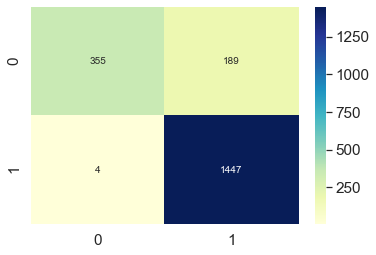

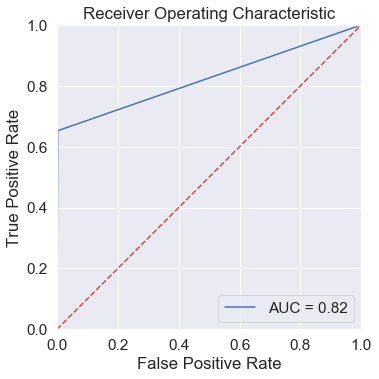

In [51]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)

In [65]:
# training an SVM on TF-IDF features
# Define the parameters to tune

parameters = {
    'C': [1, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)


KeyboardInterrupt: 

              precision    recall  f1-score   support

     related       0.98      0.85      0.91       544
   unrelated       0.95      0.99      0.97      1451

    accuracy                           0.95      1995
   macro avg       0.96      0.92      0.94      1995
weighted avg       0.96      0.95      0.95      1995



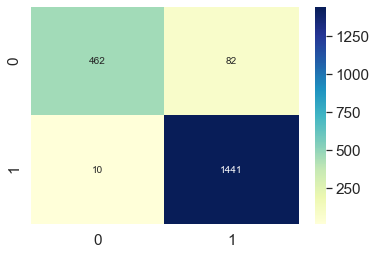

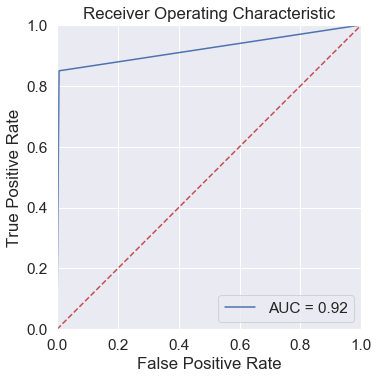

In [56]:
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confussion_matrix(y_val, y_pred)

# convert to 0s and 1s for plotting ROC curve
roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

plot_roc_curve(roc_y_val, roc_y_pred)